In [9]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


# Loading your IBM Quantum account(s)
#IBMQ.save_account('')
#provider = IBMQ.load_account()

In [10]:
#from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, execute
#from qiskit_ibm_runtime import QiskitRuntimeService
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
#from qiskit.circuit.library import MCXGate
#MCgate = MCXGate(8)


N = 8

QRn = N
CRn = N
qreg_q = QuantumRegister(QRn, 'q')#0, 8
qreg_cNnot = QuantumRegister(1, 'cx')#8
qreg_g = QuantumRegister(3, 'g')#9, 11
qreg_a = QuantumRegister(1, 'a')#12

creg_mu = ClassicalRegister(4, 'mu0')
creg_sigma = ClassicalRegister(4, 'sigma')
creg_g = ClassicalRegister(3, 'cg')
circuit = QuantumCircuit(qreg_q, qreg_cNnot, qreg_g, qreg_a, creg_mu, creg_sigma, creg_g)

def X_bit_s(s, list):
    i = 0
    while (s != 0):
        if(s & 1):
            circuit.x(list[i])
        i = i + 1
        s = s >> 1

def CnNOT_step(list, c):
    if(len(list) >= 2):
        i = len(list) - 2
        circuit.ccx(list[len(list)-2], list[len(list)-1], c)
    else:
        circuit.cx(c, list[0])
        return
    
    while(i != 0 and i != 1):
        circuit.ccx(list[i-2], list[i-1], list[i])
        i -= 2
    
    if(i == 1):
        circuit.cx(list[0], list[i])
        i += 2
    else:
        i += 4
    
    while(i < len(list)):
        circuit.ccx(list[i-2], list[i-1], list[i])
        i += 2

def CnNOT(list, c, a):
    if(len(list) % 2 == 1):
        temp = list[1:]
    else:
        temp = list[2:]
    temp.append(a)

    CnNOT_step(list, a)
    CnNOT_step(list, a)
    circuit.barrier(np.arange(min(list), max(list)+1))
    CnNOT_step(temp, c)
    CnNOT_step(temp, c)
    circuit.barrier(np.arange(min(list), max(list)+1))
    CnNOT_step(list, a)
    CnNOT_step(list, a)
    circuit.barrier(np.arange(min(list), max(list)+1))
    CnNOT_step(temp, c)
    CnNOT_step(temp, c)

def apr(reg, a, mod, acc):#reg(start, end), 0 <= start < end, 0 <= a < mod, acc >= 1, integers: start, end, acc
    a = a/mod
    i = 2
    bin_str = ""
    size = reg[1] - reg[0]
    j = 1

    while(i < mod*(10**acc) and j <= size):#!acc << test 
        if(a - 1/i >= 0):
            bin_str += "1"
            a -= 1/i
            circuit.x(reg[1] - j)
        elif(a - 1/i < 0):
            bin_str += "0"
        i = i << 1
        j += 1
    
    return(bin_str)
    
def apr_acc(bin_str, a, mod):
    apr_a = 0
    for i in range(len(bin_str)):
        if(bin_str[i] == "1"):
            apr_a += 1/(2**(i+1))
    return(apr_a*mod, apr_a, a - apr_a*mod, a/mod - apr_a)

def QFT(reg):
    for i in range(reg[1]-1, reg[0]-1, -1):
        circuit.h(i)
        for j in range(i-1, reg[0]-1, -1):
            circuit.cp(math.pi / (1 << (i - j)), j, i)
        circuit.barrier(np.arange(reg[0], reg[1]))

def RQFT(reg):
    for i in range(reg[0], reg[1]):
        for j in range(reg[0], i):
            circuit.cp(-1*math.pi / (1 << (i - j)), j, i)
        circuit.h(i)

def CSUB(reg, c, sub_a):
    for j in range(reg[0], reg[1]):
        if ((int(sub_a) >> (j - reg[0])) & 1):
            for i in range(j, reg[1]):
                circuit.cp(-1*math.pi / (1 << (i - j)), c, i)

def CADD(reg, c, add_a):
    for j in range(reg[0], reg[1]):
        if ((int(add_a) >> (j - reg[0])) & 1):
            for i in range(j, reg[1]):
                circuit.cp(math.pi / (1 << (i - j)), c, i)

def mu(reg1, reg2s, c, step):#mu > 0 at all step
    size = reg1[1]-reg1[0]
    if(reg2s != reg1[0]):
        for i in range(size):
            circuit.cx(reg1[0]+i, reg2s+i)
    #-1/(2**step)
    reg2 = (reg2s, reg2s+size)
    QFT(reg2)
    circuit.barrier(np.arange(0, N))
    CSUB(reg2, c, (2**(step)))
    circuit.barrier(np.arange(0, N))
    RQFT(reg2)

def mu_(reg1, reg2s, c, step):#mu > 0 at all step
    size = reg1[1]-reg1[0]
    #-1/(2**step)
    reg2 = (reg2s, reg2s+size)
    QFT(reg2)
    circuit.barrier(np.arange(0, N))
    CADD(reg2, c, (2**(step)))
    circuit.barrier(np.arange(0, N))
    RQFT(reg2)


def step(list, step):#list[0-3] - mu, list[4-7] - sigma, list - sorted

    #list = list_
    #list.append(20)

    f = open("step_" + str(step) + "_out_a.txt", 'r')

    temp = [row.strip().split() for row in f]

    f.close()

    for i, row in enumerate(temp):
        for j in range(0, 8):
            if(row[0][7-j] == '0'):
                circuit.x(list[j])

        CnNOT(list, qreg_a[0], qreg_cNnot[0])
        #circuit.append(MCgate, list)
        
        #circuit.cry(float(row[1]), qreg_a[0], qreg_g[step])
        circuit.ry(float(row[1])/2, qreg_g[step])
        circuit.cx(qreg_a[0], qreg_g[step])
        circuit.ry(-float(row[1])/2, qreg_g[step])
        circuit.cx(qreg_a[0], qreg_g[step])
        
        CnNOT(list, qreg_a[0], qreg_cNnot[0])
        #circuit.append(MCgate, list)

        for j in range(0, 8):
            if(row[0][7-j] == '0'):
                circuit.x(list[j])

mu0 = 4#math.pi
sigma0 = 2.0
mod = 8  #2^n n>0

apr((0, 4), mu0, mod, 2)
apr((4, 8), sigma0, mod, 2)
#circuit.h(0)
circuit.ry(math.pi/3, 0)
#circuit.h(4)
circuit.ry(math.pi/4, 4)

circuit.barrier(np.arange(0, 13))

step([0, 1, 2, 3, 4, 5, 6, 7], 0)

circuit.barrier(np.arange(0, 13))

mu((0, 4), 0, 9, 1)
step([0, 1, 2, 3, 4, 5, 6, 7], 1)

circuit.barrier(np.arange(0, 13))

mu((0, 4), 0, 10, 2)
step([0, 1, 2, 3, 4, 5, 6, 7], 2)

circuit.barrier(np.arange(0, 13))

mu_((0, 4), 0, 10, 2)

circuit.barrier(np.arange(0, 13))

mu_((0, 4), 0, 9, 1)

circuit.barrier(np.arange(0, 13))


for i in range(0, 4, 1):
    circuit.measure(qreg_q[i], creg_mu[i])

for i in range(4, 8, 1):
    circuit.measure(qreg_q[i], creg_sigma[i-4])

for i in range(0, 3, 1):
    circuit.measure(qreg_g[i], creg_g[i])

#circuit.draw()

In [11]:
#ibmq_noise_model = provider.get_backend('ibmq_quito')

#simulator = QasmSimulator.from_backend(ibmq_noise_model)

simulator = QasmSimulator()

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

#print(compiled_circuit)
#input(a)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=50000)
#job = simulator.run(circuit, shots=10000)

#QC
#job = execute(circuit, backend=ibmq_noise_model, shots=8192)

# Grab results from the job
result = job.result()


Total count are: {'000 0100 1001': 175, '100 0101 1000': 1189, '011 0100 1000': 7005, '011 0101 1000': 1002, '110 0101 1001': 309, '100 0100 1000': 9099, '110 0100 1000': 3329, '110 0101 1000': 631, '100 0100 1001': 2845, '101 0100 1000': 7081, '010 0100 1000': 3270, '101 0101 1000': 1118, '100 0101 1001': 405, '000 0100 1000': 328, '110 0100 1001': 1710, '111 0100 1001': 622, '111 0100 1000': 980, '011 0100 1001': 1704, '101 0100 1001': 2849, '001 0100 1001': 156, '111 0101 1000': 342, '001 0101 1000': 338, '101 0101 1001': 413, '111 0101 1001': 163, '001 0100 1000': 909, '010 0101 1000': 686, '010 0100 1001': 633, '000 0101 1001': 68, '011 0101 1001': 273, '001 0101 1001': 60, '000 0101 1000': 164, '010 0101 1001': 144}


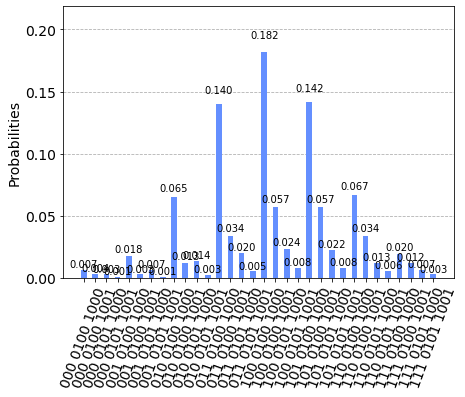

In [12]:
#counts = result.get_counts(compiled_circuit)
counts = result.get_counts()

print("\nTotal count are:", counts)

# Draw the circuit
#circuit.draw()

# Plot a histogram
plot_histogram(counts)

Вывод по различным стартовым sigma, mu: [{'000 0100 1001': 175, '100 0100 1001': 2845, '110 0100 1001': 1710, '111 0100 1001': 622, '011 0100 1001': 1704, '101 0100 1001': 2849, '001 0100 1001': 156, '010 0100 1001': 633}, {'100 0101 1000': 1189, '011 0101 1000': 1002, '110 0101 1000': 631, '101 0101 1000': 1118, '111 0101 1000': 342, '001 0101 1000': 338, '010 0101 1000': 686, '000 0101 1000': 164}, {'011 0100 1000': 7005, '100 0100 1000': 9099, '110 0100 1000': 3329, '101 0100 1000': 7081, '010 0100 1000': 3270, '000 0100 1000': 328, '111 0100 1000': 980, '001 0100 1000': 909}, {'110 0101 1001': 309, '100 0101 1001': 405, '101 0101 1001': 413, '111 0101 1001': 163, '000 0101 1001': 68, '011 0101 1001': 273, '001 0101 1001': 60, '010 0101 1001': 144}] 

Гистограмма для стартовых [sigma, mu] = ['0100', '1001']


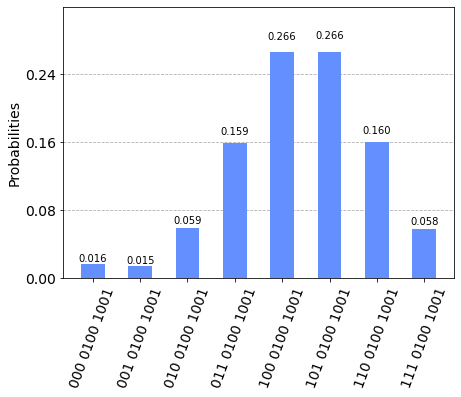

In [13]:
temp_sigma_mu = []
res_count = []

for key in counts:
    temp_ = [key[4:8], key[-4:]]
    if temp_  in temp_sigma_mu:
        res_count[temp_sigma_mu.index(temp_)][key] = counts[key]
    else:
        temp_sigma_mu.append(temp_)
        res_count.append({key: counts[key]})

i = 0
if(len(res_count) > 1):
    print("Вывод по различным стартовым sigma, mu:", res_count, '\n')
    i = int(input("Введите номер элемента res_count для построения гистограммы:"))
print("Гистограмма для стартовых [sigma, mu] =", temp_sigma_mu[i])
plot_histogram(res_count[i])